# Analysis of the data

Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import operator
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

GLOBAL VARIABLES

In [2]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath("__file__")), ".."))
DATA_DIR = os.path.join(ROOT_DIR, "data")
print(ROOT_DIR)
print(DATA_DIR)

/home/alejandro/Dropbox/Carpeta personal/Universidad - Master/2º Semestre/Natural Computing/films-synopsis-generator
/home/alejandro/Dropbox/Carpeta personal/Universidad - Master/2º Semestre/Natural Computing/films-synopsis-generator/data


Load the data

In [3]:
df = pd.read_csv(filepath_or_buffer  = os.path.join(DATA_DIR,'synopsis_genres.csv'),sep = '#',encoding = 'latin_1',index_col = 'ID')
df = df[df['Synopsis'].notnull() & df['Genre'].notnull()]
df.info()
print(str(df.head()).encode('latin1'))

<class 'pandas.core.frame.DataFrame'>
Index: 114451 entries, https://www.filmaffinity.com/es/film740563.html to https://www.filmaffinity.com/es/film469189.html
Data columns (total 2 columns):
Genre       114451 non-null object
Synopsis    114451 non-null object
dtypes: object(2)
memory usage: 2.6+ MB
b'                                                                                             Genre  \\\nID                                                                                                   \nhttps://www.filmaffinity.com/es/film740563.html                                            Comedia   \nhttps://www.filmaffinity.com/es/film275936.html  Infantil|Comedia|Animales|Perros/Lobos|Deporte...   \nhttps://www.filmaffinity.com/es/film697174.html                                      Drama|Secuela   \nhttps://www.filmaffinity.com/es/film775580.html                         Acci\xf3n|Aventuras|Espionaje   \nhttps://www.filmaffinity.com/es/film303582.html  Animaci\xf3n|Drama|Cortom

Total number of training points

In [4]:
caps = list(df['Synopsis'].map(lambda s : ' '.join(re.findall(r"[\w]+|[^\s\w]", s)).lower()).values)

total_samples=0
for text in caps:
    total_samples+=len(text.split())-1
print("Total samples : "+str(total_samples))

Total samples : 7751265


Check for the length of the sentences

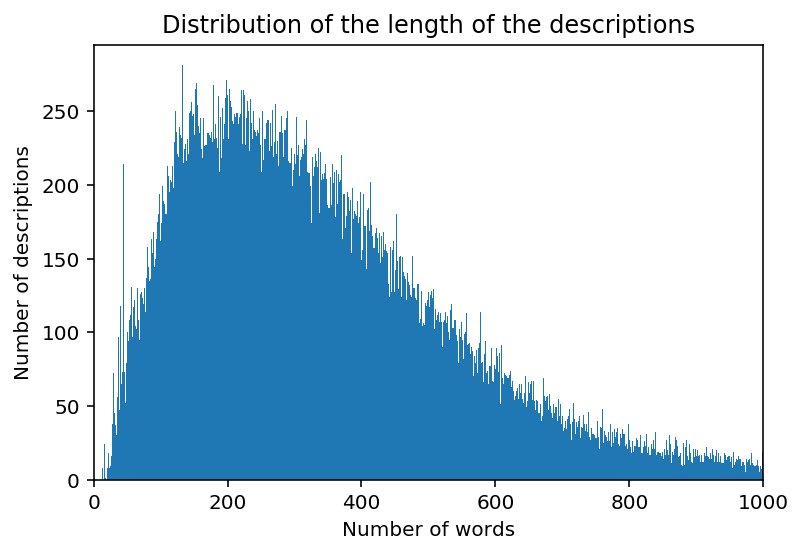

In [5]:

num_bins = range(1, 1000)

lengths = [len(entry) for entry in caps]

x = np.array(lengths)
plt.hist(x,  bins=num_bins, rwidth=2)
plt.title("Distribution of the length of the descriptions")
plt.xlabel("Number of words")
plt.ylabel("Number of descriptions")
plt.xlim(0,1000)
plt.show()

spl_by_word = [txt.split() for txt in caps]

Check frequency of the words

Total number of words: 7865716 
Size of vocabulary: 151852 
Words that appear 3 times or less: 100968 
Words that appear 2 times or less: 89855 
Words that appear 1 times or less: 68368 


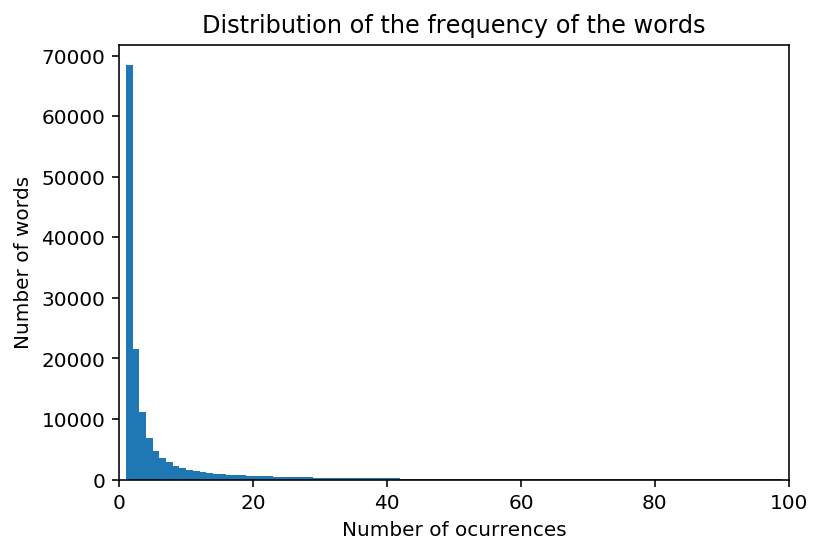

In [6]:
raw_words = []

for descrp in caps:
    raw_words.extend(descrp.split())

print("Total number of words: %d " % len(raw_words))
vocabulary = set(raw_words)
print("Size of vocabulary: %d " % len(vocabulary))


# Get all the words the occur only once for the given wordlist
desired_value = 3
myDict = dict(Counter(raw_words))
hapax_legomena = [k for k, v in myDict.items() if v <= desired_value]
print("Words that appear 3 times or less: %d " % len(hapax_legomena))
desired_value = 2
hapax_legomena = [k for k, v in myDict.items() if v <= desired_value]
print("Words that appear 2 times or less: %d " % len(hapax_legomena))
desired_value = 1
hapax_legomena = [k for k, v in myDict.items() if v <= desired_value]
print("Words that appear 1 times or less: %d " % len(hapax_legomena))



num_bins = range(1, 100)

x = np.asarray(list(myDict.values()))

plt.hist(x,  bins=num_bins, rwidth=2)
plt.title("Distribution of the frequency of the words")
plt.xlabel("Number of ocurrences")
plt.ylabel("Number of words")
plt.xlim(0,100)
plt.show()

spl_by_word = [txt.split() for txt in caps]



Check basic information about the labels

In [7]:
mlb = MultiLabelBinarizer()


genres_features = mlb.fit_transform(df['Genre'].map(lambda x: x.split('|')))
print(len(mlb.classes_)," different genres found:",str(mlb.classes_).encode('latin1')[:100],"...")
print(genres_features.shape)


378  different genres found: b"['11-S' '3-D' 'Abusos sexuales' 'Acci\xf3n' 'Acoso escolar' 'Adolescencia'\n 'Adopci\xf3n' 'Ajedrez' 'Alcoh" ...
(114451, 378)


Check the distribution of the classes

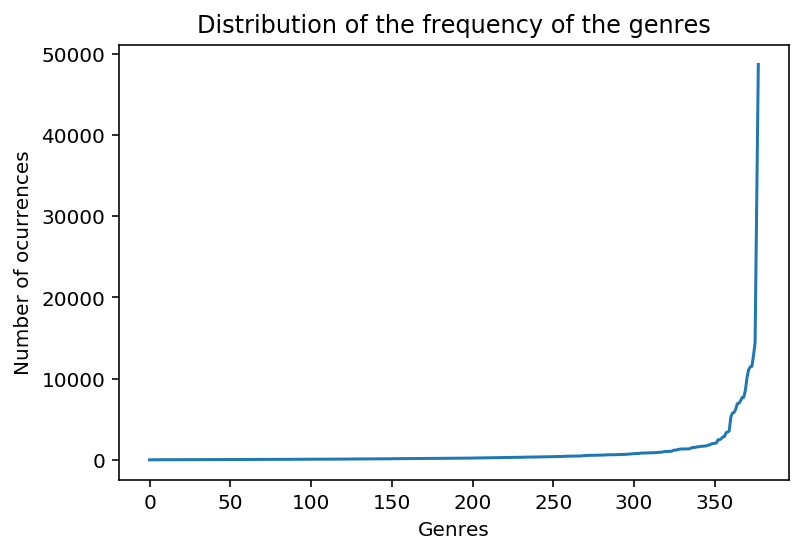

The 10 more common genre are (in descending order): ['Drama' 'Comedia' 'Documental' 'Animación' 'Romance' 'Serie de TV'
 'Thriller' 'Acción' 'Terror' 'Cortometraje']
At least one of these labels is in the 95.52122742483682% of the instances


In [8]:
genres_s = np.cumsum(genres_features, axis=0)[len(genres_features)-1,:]

plt.plot(np.sort(genres_s))
plt.title("Distribution of the frequency of the genres")
plt.xlabel("Genres")
plt.ylabel("Number of ocurrences")
plt.show()

top = 10

most_common = np.sort(genres_s)[len(genres_s)-top:len(genres_s)][::-1]
genres_s = genres_s.tolist()
#indexes = genres_s.tolist().index(np.sort(genres_s)[len(genres_s)-25:len(genres_s)])
indexes = [genres_s.index(value) for value in most_common]
print("The {} more common genre are (in descending order): {}".format(len(indexes),mlb.classes_[indexes]))

count = 0
#df['Genre'].map(lambda x: x.split('|'))
for entry in df['Genre'].map(lambda x: x.split('|')):
    if np.any(np.in1d(mlb.classes_[indexes], entry)):
#    if any mlb.classes_[indexes] in entry:
        count += 1

#print(count)

print("At least one of these labels is in the {}% of the instances".format(count/len(df['Genre'])*100))


Co-occurence Matrices

In [16]:
most_common_text = mlb.classes_[indexes]
most_common_index = indexes
most_common_value = most_common

tags = most_common_text


subset = []
sub_genres_features = genres_features[:,most_common_index]
#df['Genre'].map(lambda x: x.split('|'))
for i, entry in enumerate(df['Genre'].map(lambda x: x.split('|'))):
    if np.any(np.in1d(mlb.classes_[indexes], entry)):
        subset.append(sub_genres_features[i])

np_ground_truth = np.asarray(subset)

#print(np_ground_truth[:20])

# Co-occurence Matrices
com_ground_truth = np.zeros([len(tags)]*2)
for l, tag in enumerate(tags):
        for l2, tag2 in enumerate(tags):
            if np_ground_truth[:,l].sum()>0:
                com_ground_truth[l, l2] = np_ground_truth[:,l].dot(np_ground_truth[:,l2])/np_ground_truth[:,l].sum()
            else:
                com_ground_truth[l, l2] = 0

# Plotting
data=go.Heatmap(z=com_ground_truth, x=list(tags), y=list(tags))

fig = tls.make_subplots(rows=1, cols=2, subplot_titles=('Co-occurrence matrix','Co-occurrence matrix (copy)'))
fig.append_trace(data, 1, 1)
fig.append_trace(data, 1, 2)

py.iplot(fig)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

